<a href="https://colab.research.google.com/github/amoyag/Biofisica/blob/main/S2_NAR_profesor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#@title Módulo 0: Librerías y configuración inicial
# ============================================

# Librerías numéricas y científicas
import numpy as np
from scipy.integrate import solve_ivp

# Librerías para visualización
import matplotlib.pyplot as plt
#import seaborn as sns

# Configuración de gráficos
#plt.style.use("seaborn-v0_8")
#sns.set_context("talk")
plt.style.use("default")



# Librerías para análisis de datos
import pandas as pd

# Configuración general
%matplotlib inline

# Semilla para reproducibilidad
np.random.seed(42)

#print("Entorno listo: NumPy, SciPy, Matplotlib, Seaborn, Pandas importados.")

In [2]:
#@title Módulo 1: Modelo del circuito
def model_nar(t, y, params):
    """
    Modelo de autorregulación negativa.

    dY/dt = beta / (1 + (Y/K)^n) - alpha * Y

    Parámetros:
    - params: diccionario con claves:
        beta: tasa máxima de síntesis
        K: constante de inhibición
        n: coeficiente de Hill
        alpha: tasa de degradación
    """
    Y = y[0]
    beta = params["beta"]
    K = params["K"]
    n = params["n"]
    alpha = params["alpha"]

    dYdt = beta / (1 + (Y / K)**n) - alpha * Y
    return [dYdt]



def model_simple(t, y, params):
    """
    Modelo sin autorregulación (regulación simple):

    dY/dt = beta - alpha * Y

    Parámetros:
    - params: diccionario con claves:
        beta: tasa de síntesis
        alpha: tasa de degradación
    """
    Y = y[0]
    beta = params["beta"]
    alpha = params["alpha"]
    dYdt = beta - alpha * Y
    return [dYdt]


In [3]:
#@title Módulo 2: Configuracion de la simulación
def build_config(model_params, t_span=(0, 60), num_points=600, y0=[0.0]):
    """
    Construye la configuración para la simulación.

    Retorna:
    - params: diccionario con parámetros del modelo
    - y0: condiciones iniciales
    - t_span: tupla (inicio, fin)
    - t_eval: array de tiempos
    """
    import numpy as np
    t_eval = np.linspace(t_span[0], t_span[1], num_points)
    return model_params, y0, t_span, t_eval



In [4]:
#@title Módulo 3: Eejecución de la simulación
def run_simulation(model_func, params, y0, t_span, t_eval):
    """
    Ejecuta la simulación usando solve_ivp.

    Retorna:
    - sol: objeto con resultados (tiempos y valores)
    """
    sol = solve_ivp(fun=lambda t, y: model_func(t, y, params),
                    t_span=t_span, y0=y0, t_eval=t_eval)
    return sol

In [5]:
#@title Módulo 4: Visualización


def plot_timeseries(sol, labels=None, title="Dinámica temporal"):
    """
    Grafica las series temporales de la simulación con estilo clásico (fondo blanco).

    Parámetros:
    - sol: objeto devuelto por solve_ivp (contiene sol.t y sol.y)
    - labels: lista opcional con nombres para cada variable
    - title: título del gráfico
    """
    plt.figure(figsize=(7, 4))

    # Iterar sobre todas las variables del sistema
    for i in range(sol.y.shape[0]):
        lab = labels[i] if labels and i < len(labels) else f"var{i}"
        plt.plot(sol.t, sol.y[i], label=lab)

    # Etiquetas y título (estilo simple)
    plt.xlabel("Tiempo")
    plt.ylabel("Concentración (a.u.)")
    plt.title(title)

    # Leyenda y disposición
    plt.legend()
    plt.tight_layout()
    plt.show()





In [6]:
#@title Módulo 5: tiempo de respuesta
def compute_half_time(sol):
    """
    Calcula el tiempo para alcanzar el 50% del estado estacionario.
    """
    Y_final = sol.y[0][-1]
    half_value = 0.5 * Y_final
    # Buscar el primer tiempo donde Y >= half_value
    for t, y in zip(sol.t, sol.y[0]):
        if y >= half_value:
            return t
    return None

In [7]:
#@title Módulo 6: Análisis de ruido
def noisy_input(t, sigma=0.2):
    """
    Genera ruido gaussiano para simular entrada fluctuante.
    """
    return np.random.normal(0, sigma)

def analyze_noise_effect(model_func, base_params, y0, t_span, t_eval, sigma_list):
    """
    Compara desviación estándar de salida frente a ruido.

    Retorna:
    - dict con sigma: (std_out)
    """
    results = {}
    for sigma in sigma_list:
        Y_values = []
        current_y = y0[0]
        for t in t_eval:
            # Actualizar beta con ruido
            params = base_params.copy()
            params["beta"] += noisy_input(t, sigma)
            # Paso de integración simple (Euler)
            dYdt = model_func(t, [current_y], params)[0]
            current_y += dYdt * (t_eval[1] - t_eval[0])
            Y_values.append(current_y)
        results[sigma] = np.std(Y_values)
    return results


In [8]:
#@title Módulo 7: Barrido de parámetros
def compute_steady_state(model_func, params, y0, t_span, t_eval):
    """
    Ejecuta simulación y retorna el valor estacionario.
    """
    sol = run_simulation(model_func, params, y0, t_span, t_eval)
    return sol.y[0][-1]

def parameter_scan(model_func, beta_range, alpha_range, fixed_params, y0, t_span, t_eval):
    """
    Barrido de parámetros beta y alpha.

    Retorna:
    - matriz con valores estacionarios
    """
    results = np.zeros((len(beta_range), len(alpha_range)))
    for i, beta in enumerate(beta_range):
        for j, alpha in enumerate(alpha_range):
            params = fixed_params.copy()
            params["beta"] = beta
            params["alpha"] = alpha
            results[i, j] = compute_steady_state(model_func, params, y0, t_span, t_eval)
    return results


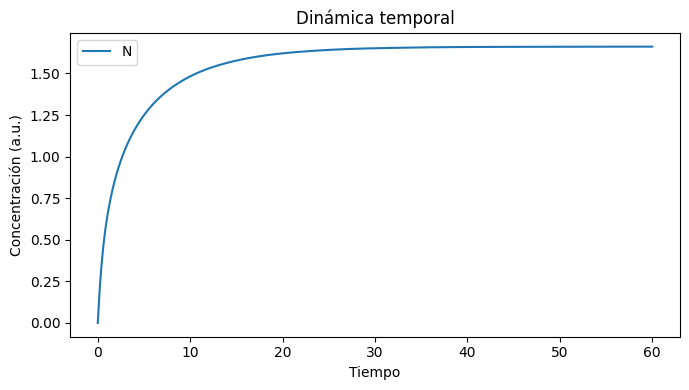

Tiempo para alcanzar el 50% del estado estacionario: 1.80 unidades de tiempo


In [9]:
#@title Simulación genérica de NAR
# ============================================

# 1. Definir parámetros del modelo
params_nar = {
    "beta": 1.0,   # tasa máxima de síntesis
    "alpha": 0.05, # tasa de degradación
    "K": 0.5,      # constante de inhibición
    "n": 2         # coeficiente de Hill
}

# 2. Construir configuración de simulación
model_params, y0, t_span, t_eval = build_config(params_nar, t_span=(0, 60), num_points=600, y0=[0.0])

# 3. Ejecutar la simulación
sol_nar = run_simulation(model_nar, model_params, y0, t_span, t_eval)

# 4. Visualizar la dinámica
plot_timeseries(sol_nar, labels="NAR")

# 5. Calcular tiempo de respuesta (t_1/2)
t_half = compute_half_time(sol_nar)
print(f"Tiempo para alcanzar el 50% del estado estacionario: {t_half:.2f} unidades de tiempo")


## Ejercicios

### Ejercicio 1: Comparación del tiempo de respuesta con y sin autorregulación negativa
Objetivo:
Comprobar que la autorregulación negativa acelera la respuesta del sistema en comparación con un circuito sin autorregulación.
Instrucciones:

Simula dos circuitos:

Circuito simple: sin autorregulación (usa model_simple).
Circuito con NAR: autorregulación negativa (usa model_nar).


Usa los mismos parámetros básicos para ambos modelos:

$\beta = 1.0, \alpha = 0.05$. Para NAR añade: $K = 0.5, n = 2$.


Calcula el tiempo para alcanzar el 50% del estado estacionario $t_{\frac{1}{2}}$ en ambos casos.
Representa las curvas temporales en un mismo gráfico y compara visualmente.
Pregunta: ¿qué sistema responde más rápido y por qué?

---

#### **Plantilla**
Utiliza esta plantilla para preparar tu simulación:



```python

# ============================================
# EJERCICIO 1: Comparación del tiempo de respuesta
# ============================================

# 1. Definir parámetros para ambos modelos
params_simple = {...}
params_nar = {...}

# 2. Construir configuración común
model_params_simple, y0, t_span, t_eval = build_config(...)
model_params_nar, _, _, _ = build_config(...)

# 3. Ejecutar simulaciones
sol_simple = run_simulation(model_simple, ...)
sol_nar = run_simulation(model_nar, ...)

# 4. Visualizar resultados (puedes usar plot_timeseries o un gráfico combinado)
plot_timeseries(...)
plot_timeseries(...)

# 5. Calcular tiempos de respuesta
t_half_simple = compute_half_time(...)
t_half_nar = compute_half_time(...)
print(f"Tiempo para alcanzar 50% del estado estacionario:")
print(f" - Sin autorregulación: {...:.2f}")
print(f" - Con autorregulación negativa: {...:.2f}")
```


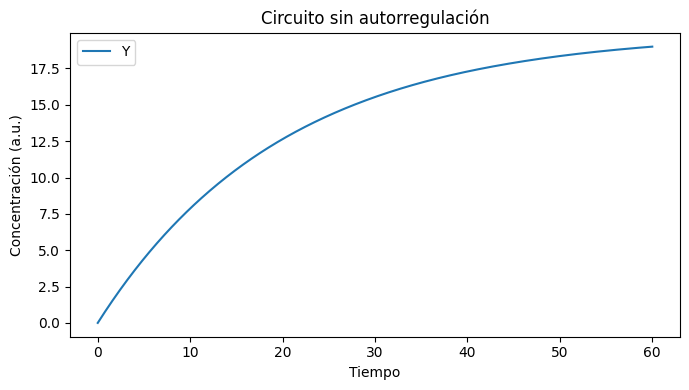

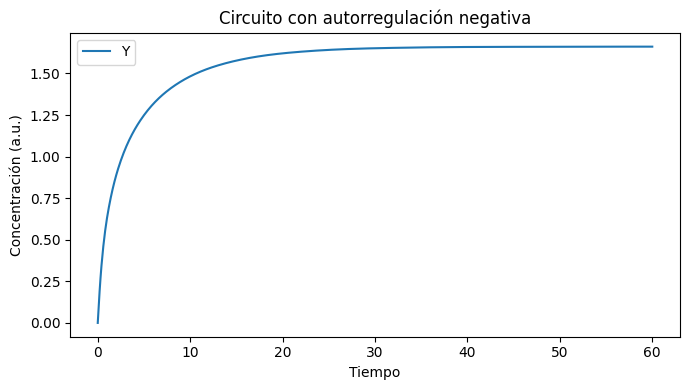

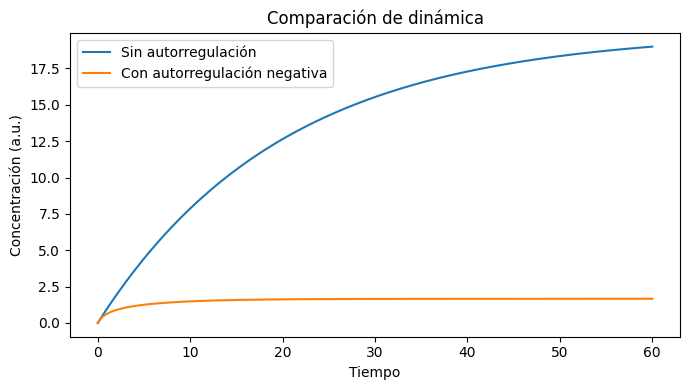

Tiempo para alcanzar 50% del estado estacionario:
 - Sin autorregulación: 12.92
 - Con autorregulación negativa: 1.80


In [10]:
#@title Solución Ejercicio 1
# ============================================
# EJERCICIO 1: Comparación del tiempo de respuesta
# ============================================

# 1. Definir parámetros para ambos modelos
params_simple = {"beta": 1.0, "alpha": 0.05}
params_nar = {"beta": 1.0, "alpha": 0.05, "K": 0.5, "n": 2}

# 2. Construir configuración común
model_params_simple, y0, t_span, t_eval = build_config(params_simple)
model_params_nar, _, _, _ = build_config(params_nar)

# 3. Ejecutar simulaciones
sol_simple = run_simulation(model_simple, model_params_simple, y0, t_span, t_eval)
sol_nar = run_simulation(model_nar, model_params_nar, y0, t_span, t_eval)

# 4. Visualizar resultados
plot_timeseries(sol_simple, labels=["Y"], title="Circuito sin autorregulación")
plot_timeseries(sol_nar, labels=["Y"], title="Circuito con autorregulación negativa")

# 5. Comparación en un mismo gráfico
plt.figure(figsize=(7,4))
plt.plot(sol_simple.t, sol_simple.y[0], label="Sin autorregulación")
plt.plot(sol_nar.t, sol_nar.y[0], label="Con autorregulación negativa")
plt.xlabel("Tiempo")
plt.ylabel("Concentración (a.u.)")
plt.title("Comparación de dinámica")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Calcular tiempos de respuesta
t_half_simple = compute_half_time(sol_simple)
t_half_nar = compute_half_time(sol_nar)

print(f"Tiempo para alcanzar 50% del estado estacionario:")
print(f" - Sin autorregulación: {t_half_simple:.2f}")
print(f" - Con autorregulación negativa: {t_half_nar:.2f}")
